#### Problem statement:- 
Build a system to identify spam emails. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import re
import string
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet 
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.tokenize import word_tokenize, sent_tokenize

from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import plot_roc_curve

from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load data set
df = pd.read_csv("messages.csv")
df.head()

,subject,message,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,NaN,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0


In [3]:
df.shape

(2893, 3)

In [4]:
# check for null values
df.isnull().sum()

subject    62
message     0
label       0
dtype: int64

In [5]:
# subject has 62 null data, we can replace that with a ""
df.fillna(" ", inplace=True)

In [6]:
df.isnull().sum()

subject    0
message    0
label      0
dtype: int64

In [7]:
# Lets combine subject and message 
df['description'] = df[['subject', 'message']].apply(lambda x: ' '.join(x), axis = 1)

In [8]:
# Add length column 
df['length'] = df.description.str.len()
df.head()

,subject,message,label,description,length
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0,job posting - apple-iss research center conten...,2896
1,,"lang classification grimes , joseph e . and ba...",0,"lang classification grimes , joseph e . and ...",1802
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0,query : letter frequencies for text identifica...,1486
3,risk,a colleague and i are researching the differin...,0,risk a colleague and i are researching the dif...,329
4,request book information,earlier this morning i was on the phone with a...,0,request book information earlier this morning ...,1071


In [9]:
# Lets drop subject and message columns
df.drop(['subject','message'],axis=1,inplace=True)

In [10]:
df.head()

,label,description,length
0,0,job posting - apple-iss research center conten...,2896
1,0,"lang classification grimes , joseph e . and ...",1802
2,0,query : letter frequencies for text identifica...,1486
3,0,risk a colleague and i are researching the dif...,329
4,0,request book information earlier this morning ...,1071


In [11]:
df.label.value_counts()

0    2412
1     481
Name: label, dtype: int64

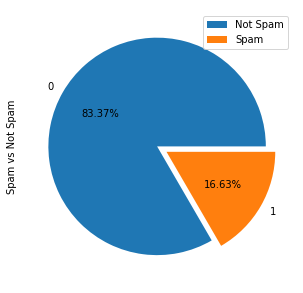

In [12]:
df.label.value_counts().plot(kind = 'pie', explode=[0, 0.1], figsize = (5, 5), autopct= '%1.2f%%')
plt.ylabel("Spam vs Not Spam")
plt.legend(["Not Spam", "Spam"])

In [13]:
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    

In [14]:
def clean_text(text):
    text = text.lower()
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    text = [word for word in text if not any(b.isdigit() for b in word)]
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    text = [t for t in text if len(t) > 0]
    pos_tags = pos_tag(text)
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    text = [t for t in text if len(t) > 1]
    text = " ".join(text)
    return(text)

In [15]:
df["description_cleaned"] = df["description"].apply(lambda x: clean_text(x))

In [16]:
df.head()

,label,description,length,description_cleaned
0,0,job posting - apple-iss research center conten...,2896,job post apple-iss research center content len...
1,0,"lang classification grimes , joseph e . and ...",1802,lang classification grime joseph barbara grime...
2,0,query : letter frequencies for text identifica...,1486,query letter frequency text identification pos...
3,0,risk a colleague and i are researching the dif...,329,risk colleague research differ degree risk per...
4,0,request book information earlier this morning ...,1071,request book information earlier morning phone...


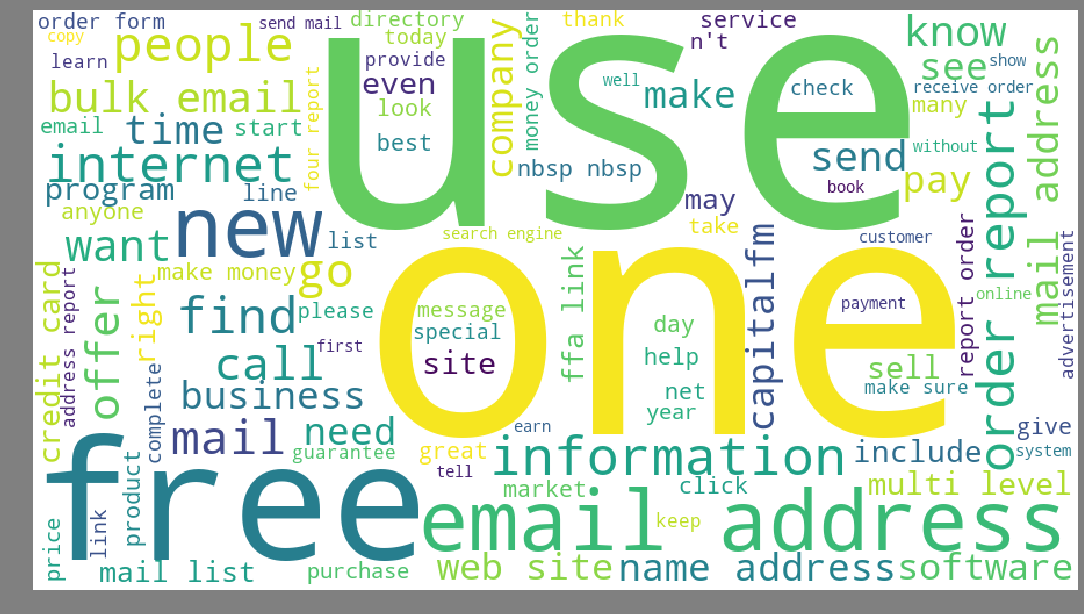

In [29]:

spams = df['description_cleaned'][df['label']==1]

spam_cloud = WordCloud(width=900,height=500,background_color='white',max_words=100).generate(' '.join(spams))
plt.figure(figsize=(15,18),facecolor='grey')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

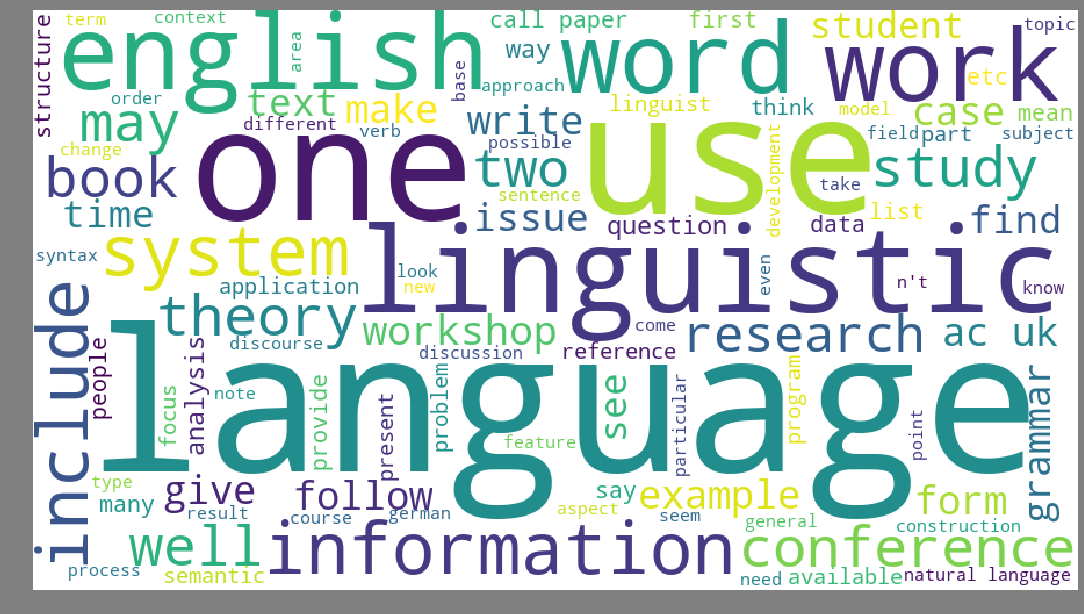

In [30]:
non_spams = df['description_cleaned'][df['label']==0]

non_spam_cloud = WordCloud(width=900,height=500,background_color='white',max_words=100).generate(' '.join(non_spams))

plt.figure(figsize=(15,18),facecolor='grey')
plt.imshow(non_spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [22]:
tf_vec = TfidfVectorizer()
X = tf_vec.fit_transform(df['description_cleaned'])
y = df['label']

In [23]:
X.shape, y.shape

((2893, 49758), (2893,))

In [50]:
# Split into train & test set
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    random_state=78)

In [51]:
# Put models into Dictionary
models = {"Logistic Regression": LogisticRegression(),
           "KNN": KNeighborsClassifier(),
           "Random Forest": RandomForestClassifier(),
           "Naive Bayes": MultinomialNB() }

# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    model_scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [52]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)

model_scores

{'Logistic Regression': 0.9706390328151986,
 'KNN': 0.9930915371329879,
 'Random Forest': 0.9792746113989638,
 'Naive Bayes': 0.8652849740932642}

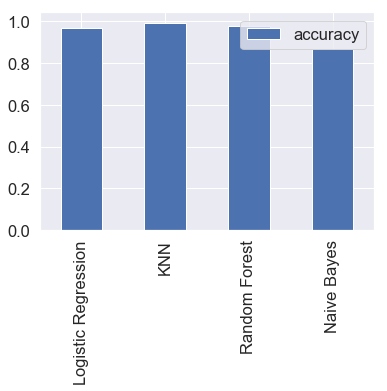

In [53]:
# Compare models
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare.T.plot.bar();

In [44]:
def max_acc_score(reg, x, y):
    max_acc_score=0
    for r_state in range(42,101):
        X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = r_state, test_size=0.20)
        reg.fit(X_train, y_train)
        pred = reg.predict(X_test)
        acc_score=accuracy_score(y_test, pred)
        if acc_score > max_acc_score:
            max_acc_score = acc_score
            final_r_state = r_state
    print("The max accuracy score for", reg, "is: ", max_acc_score, " achieved at", final_r_state)
   

In [45]:
knn = KNeighborsClassifier()
max_acc_score(knn, X, y)

The max accuracy score for KNeighborsClassifier() is:  0.9930915371329879  achieved at 78


In [54]:
# KNN is giving highest accuracy, Let's tune KNN

train_scores = []
test_scores = []

# Create a list of differnt values for n_neighbors
neighbors = range(1, 21)

# Setup KNN instance
knn = KNeighborsClassifier()

# Loop through different n_neighbors
for i in neighbors:
    knn.set_params(n_neighbors=i)
    
    # Fit the algorithm
    knn.fit(X_train, y_train)
    
    # Update the training scores list
    train_scores.append(knn.score(X_train, y_train))
    
    # Update the test scores list
    test_scores.append(knn.score(X_test, y_test))

In [55]:
train_scores

[1.0,
 0.9926534140017286,
 0.9917891097666378,
 0.9917891097666378,
 0.9878997407087294,
 0.9883318928262749,
 0.986171132238548,
 0.986171132238548,
 0.9818496110630942,
 0.9835782195332757,
 0.9814174589455489,
 0.9835782195332757,
 0.9814174589455489,
 0.9848746758859118,
 0.9818496110630942,
 0.9844425237683665,
 0.9796888504753674,
 0.9809853068280034,
 0.9775280898876404,
 0.9783923941227312]

In [56]:
test_scores

[0.9810017271157168,
 0.9827288428324698,
 0.9896373056994818,
 0.9913644214162349,
 0.9930915371329879,
 0.9913644214162349,
 0.9896373056994818,
 0.9896373056994818,
 0.9879101899827288,
 0.9896373056994818,
 0.9861830742659758,
 0.9879101899827288,
 0.9861830742659758,
 0.9879101899827288,
 0.9844559585492227,
 0.9861830742659758,
 0.9861830742659758,
 0.9861830742659758,
 0.9844559585492227,
 0.9844559585492227]

Maximum KNN score on the test data: 99.31%


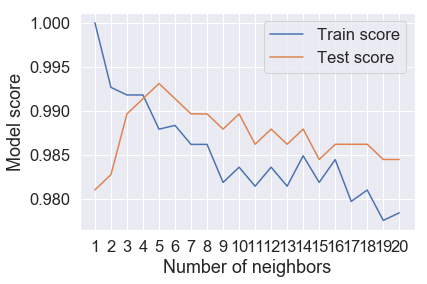

In [57]:
plt.plot(neighbors, train_scores, label="Train score")
plt.plot(neighbors, test_scores, label="Test score")
plt.xticks(np.arange(1, 21, 1))
plt.xlabel("Number of neighbors")
plt.ylabel("Model score")
plt.legend()

print(f"Maximum KNN score on the test data: {max(test_scores)*100:.2f}%")

In [58]:
# Make predictions with tuned model
y_preds = knn.predict(X_test)

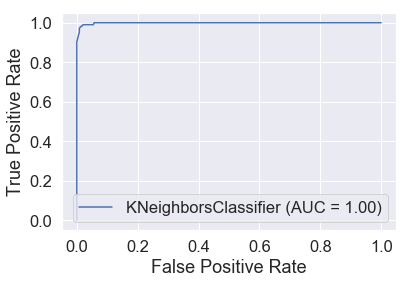

In [59]:
# Plot ROC curve and calculate AUC metric
plot_roc_curve(knn, X_test, y_test)

In [60]:
# Cross-validated accuracy
cv_acc = cross_val_score(knn,
                         X,
                         y,
                         cv=5,
                         scoring="accuracy")
cv_acc

array([0.97236615, 0.97582038, 0.98100173, 0.96193772, 0.97750865])

In [61]:
cv_acc = np.mean(cv_acc)
cv_acc

0.9737269244790265

In [62]:
# Confusion matrix
print(confusion_matrix(y_test, y_preds))

[[469   7]
 [  2 101]]


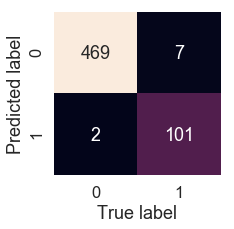

In [63]:
sns.set(font_scale=1.5)

def plot_conf_mat(y_test, y_preds):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True,
                     cbar=False,
                     fmt="d")
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    
    
plot_conf_mat(y_test, y_preds)

In [64]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       476
           1       0.94      0.98      0.96       103

    accuracy                           0.98       579
   macro avg       0.97      0.98      0.97       579
weighted avg       0.98      0.98      0.98       579

